## Import library

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import yaml
import re
import matplotlib.pyplot as plt
import os
# print(os.getcwd())
# os.chdir("NLP_ENSAE_Project/")
# os.getcwd()

pd.set_option('future.no_silent_downcasting', True)

## Load data and tokens

In [2]:
!cd NLP_ENSAE_Project
with open(f'../data/entities.json', 'r') as file:
    data = json.load(file)

with open(f'../data/tokens.yml', 'r') as file:
    tokens = yaml.safe_load(file)
    
token_dict = {}
for col in tokens.keys():
    token = tokens[col]['start']
    token_dict[token] = col

token_dict

/bin/bash: line 1: cd: NLP_ENSAE_Project: No such file or directory


{'Ⓐ': 'age',
 'Ⓑ': 'birth_date',
 'Ⓒ': 'civil_status',
 'Ⓓ': 'education_level',
 'Ⓔ': 'employer',
 'Ⓕ': 'firstname',
 'Ⓗ': 'link',
 'Ⓘ': 'lob',
 'Ⓙ': 'maiden_name',
 'Ⓚ': 'nationality',
 'Ⓛ': 'observation',
 'Ⓜ': 'occupation',
 'Ⓞ': 'surname',
 'Ⓟ': 'surname_household'}

In [3]:
## Some Useful functions in my own .py

In [4]:
os.chdir("../")
from src.useful_functions import *

## Preprocessing

In [5]:
df = get_preprocessing_done(data, tokens,  token_dict)
df = df.rename(columns={"surname_household": "Is_household"})
X = df.drop(columns=['Is_household'])
y = df['Is_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )

100%|██████████| 1218/1218 [00:00<00:00, 2166.92it/s]


In [6]:
X

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25433,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN
25434,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,idem,NaN,ouv chaus res,NaN
25435,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN
25436,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti


In [7]:
y

0        0
1        1
2        1
3        1
4        0
        ..
25433    1
25434    1
25435    1
25436    0
25437    0
Name: Is_household, Length: 25074, dtype: int64

## Antoine

## Avec Surname

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import time

In [9]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y, test_size=0.20, stratify=y)

In [10]:
description_features_string = [
    'civil_status',
    'education_level',
    'employer',
    'firstname',
    'link',
    'lob',
    'maiden_name',
    'nationality',
    'observation',
    'occupation',
    'surname'
]
description_features_num = [
    'age',
    'birth_date'
]
target_features = ['Is_household']

In [11]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [
        (
            "string",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_string,
        )
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("scaler", StandardScaler()),
    ]
)
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(class_weight='balanced',random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 1.555s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Inference Time: 0.193s
Notre accuracy de test est de : 0.8309072781655035
Classification report
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3887
           1       0.57      0.98      0.72      1128

    accuracy                           0.83      5015
   macro avg       0.78      0.88      0.80      5015
weighted avg       0.90      0.83      0.84      5015



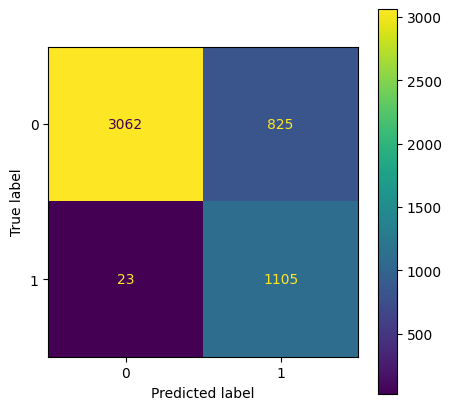

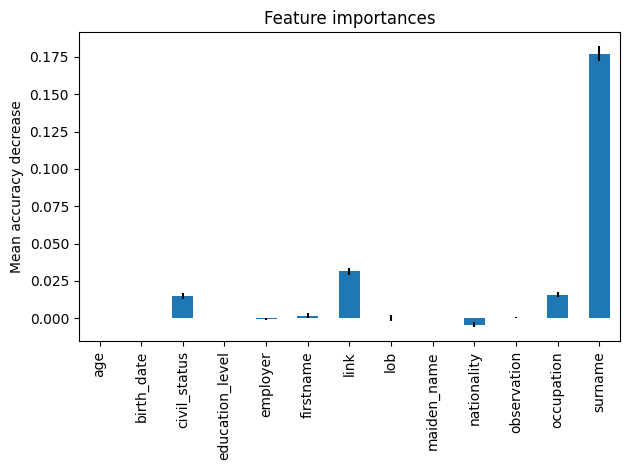

In [12]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [13]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", BalancedRandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Training time: 1.335s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 BalancedRandomForestClassifier(random_state=42))])

Inference Time: 0.169s
Notre accuracy de test est de : 0.7914257228315055
Classification report
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      3887
           1       0.52      1.00      0.68      1128

    accuracy                           0.79      5015
   macro avg       0.76      0.86      0.76      5015
weighted avg       0.89      0.79      0.81      5015



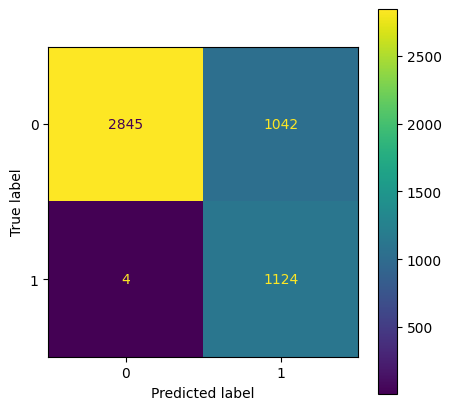

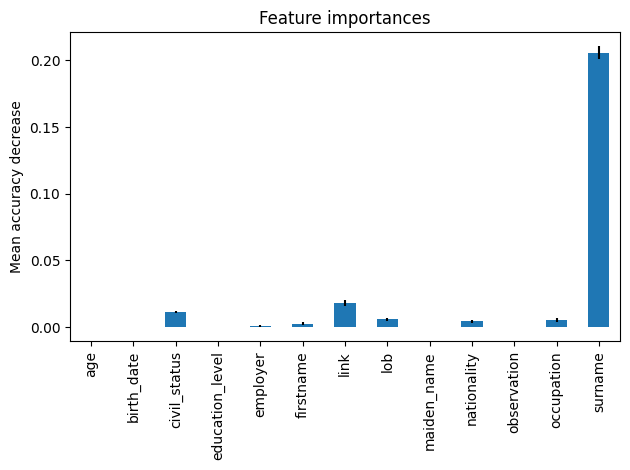

In [14]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [15]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", HistGradientBoostingClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 0.632s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

Inference Time: 0.148s
Notre accuracy de test est de : 0.8245264207377866
Classification report
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3887
           1       0.56      0.98      0.71      1128

    accuracy                           0.82      5015
   macro avg       0.78      0.88      0.79      5015
weighted avg       0.90      0.82      0.84      5015



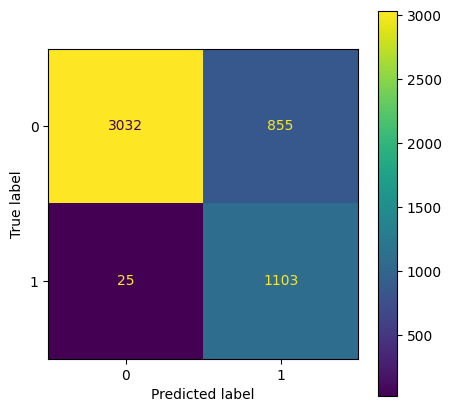

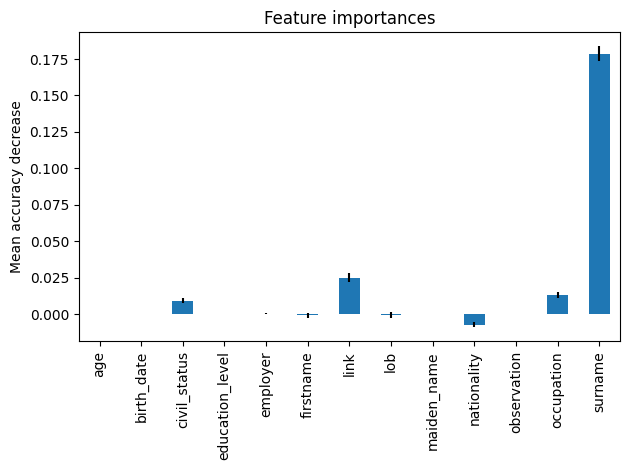

In [16]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

## Sans surname

In [17]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X.drop(['surname'], axis = 1), y, test_size=0.20, stratify=y)
description_features_string = [
    'civil_status',
    'education_level',
    'employer',
    'firstname',
    'link',
    'lob',
    'maiden_name',
    'nationality',
    'observation',
    'occupation'
]

In [18]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [
        (
            "string",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_string,
        )
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("scaler", StandardScaler()),
    ]
)
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 2.352s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=42))])

Inference Time: 0.189s
Notre accuracy de test est de : 0.9160518444666002
Classification report
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3887
           1       0.81      0.82      0.81      1128

    accuracy                           0.92      5015
   macro avg       0.88      0.88      0.88      5015
weighted avg       0.92      0.92      0.92      5015



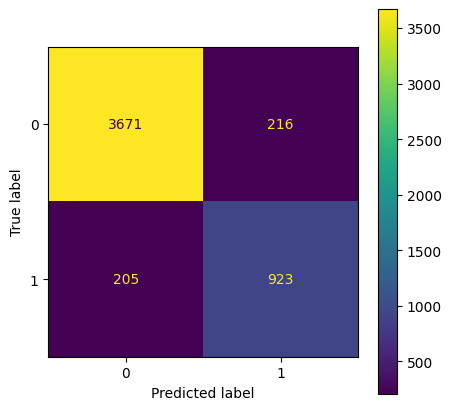

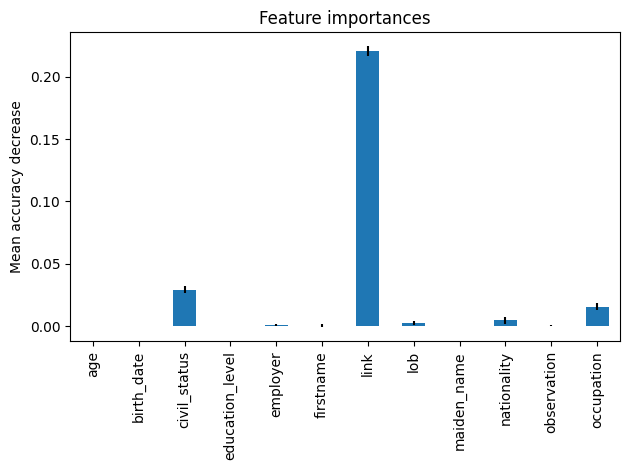

In [19]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [20]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", BalancedRandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Training time: 1.912s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 BalancedRandomForestClassifier(random_state=42))])

Inference Time: 0.19s
Notre accuracy de test est de : 0.9204386839481555
Classification report
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      3887
           1       0.76      0.95      0.84      1128

    accuracy                           0.92      5015
   macro avg       0.87      0.93      0.89      5015
weighted avg       0.93      0.92      0.92      5015



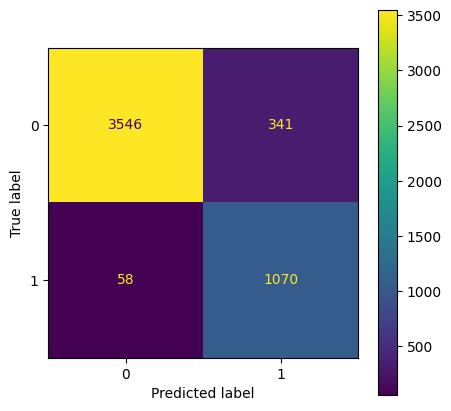

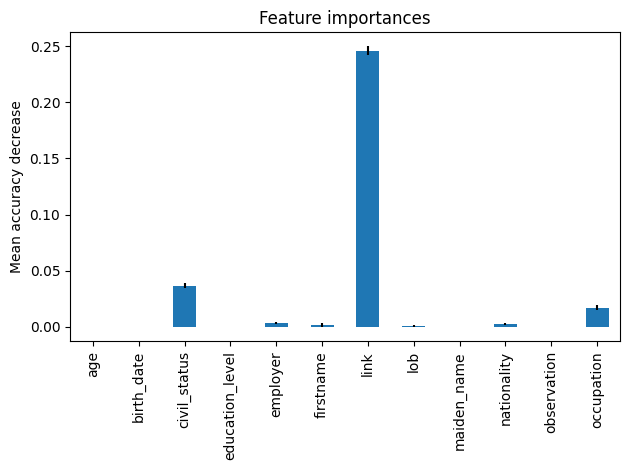

In [21]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [22]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", HistGradientBoostingClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 0.693s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

Inference Time: 0.111s
Notre accuracy de test est de : 0.9258225324027917
Classification report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3887
           1       0.79      0.91      0.85      1128

    accuracy                           0.93      5015
   macro avg       0.88      0.92      0.90      5015
weighted avg       0.93      0.93      0.93      5015



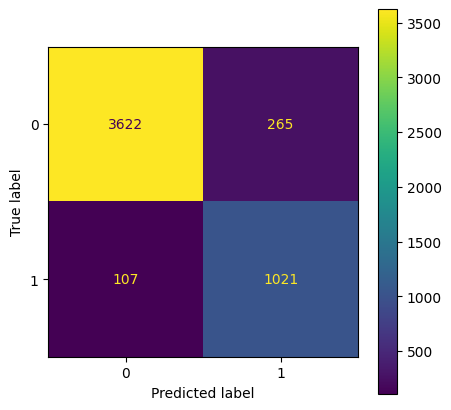

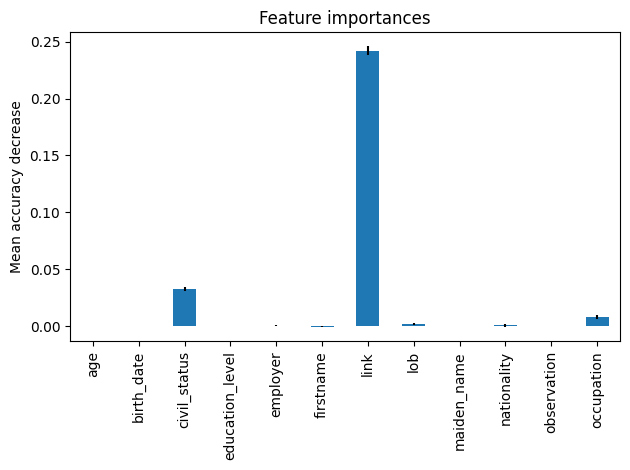

In [23]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)